In [1]:
import os

# Change to the parent directory
os.chdir('..')
from utils.visualizer import SoccerVisualizer
import torch
import numpy as np

FEATURE_DIR = 'data/soccer_shards'
TARGET_DIR = 'data/soccer_shards_targets'



# Helper Functions

In [2]:
def load_first_shard():
    fpaths = sorted([os.path.join(FEATURE_DIR, f) for f in os.listdir(FEATURE_DIR) if f.endswith(".pt")])
    tpaths = sorted([os.path.join(TARGET_DIR,  f) for f in os.listdir(TARGET_DIR)  if f.endswith(".pt")])
    if not fpaths or not tpaths:
        raise FileNotFoundError("No shard .pt files found.")

    feats = torch.load(fpaths[0], map_location="cpu")['X']  # (C, N, W, H)
    targs = torch.load(tpaths[0],  map_location="cpu")['targets'] # (N, 3) or (3, N)
    if targs.dim() == 2 and targs.shape[0] == 3 and targs.shape[1] != 3:
        targs = targs.t().contiguous()
    assert feats.dim() == 4 and targs.dim() == 2 and targs.shape[1] == 3
    return feats, targs

def get_example(feats_cnwH, targs_n3, i):
    C, N, W, H = feats_cnwH.shape
    if i < 0 or i >= N:
        raise IndexError(f"Index {i} out of range (N={N}).")
    x = feats_cnwH[:, i, :, :]        # (C, W, H)
    # Ensure (C, H, W) = (C, 105, 68)
    if x.shape[-2] in (68, 34, 17) and x.shape[-1] in (105, 52, 26):
        x = x.permute(0, 2, 1).contiguous()
    dst_xy = targs_n3[i, :2].clone()  # (x, y)
    y      = targs_n3[i, 2].clone()   # 0/1
    return x, dst_xy, y

## Load Shard and Definitions

In [15]:
# X: (C, H, W) tensor for one frame
# channel indices based on your manifest ordering
DIST, SINB, COSB, POS, DEF, SING, COSG, DISTG, BVX, BVY, AVX, AVY, DVX, DVY = range(14)

feats, targs = load_first_shard()

feats.shape



torch.Size([14, 20138, 105, 68])

## Regular State Plotting

tensor(1, dtype=torch.int16)


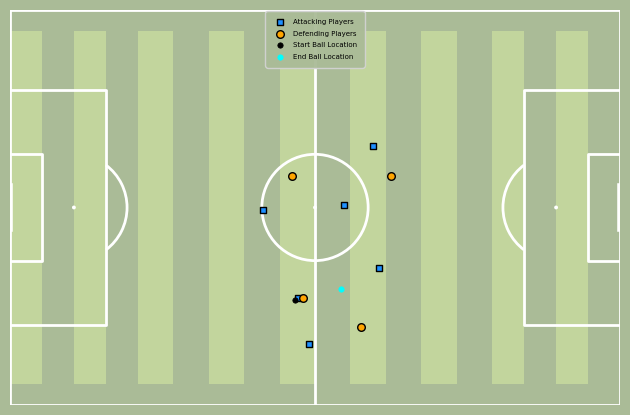

In [4]:
EXAMPLE_IDX = np.random.randint(0,20000)

X, dst_xy, y = get_example(feats, targs, EXAMPLE_IDX)


viz = SoccerVisualizer()

ball_dist = X[DIST]
in_pos = X[POS]          # (105, 68) one-hot
out_pos = X[DEF]
ball_vx = X[BVX]
ball_vy = X[BVY]
att_vx = X[AVX]
att_vy = X[AVY]
def_vx = X[DVX]
def_vy = X[DVY]

fig, ax, artists = viz.plot_state(
    in_possession=in_pos,
    out_possession=out_pos,
)
dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y == 1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="cyan", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)

print(y)

## Velocity Stuff

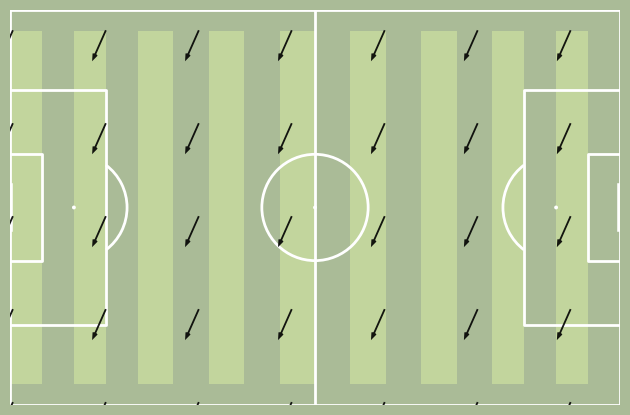

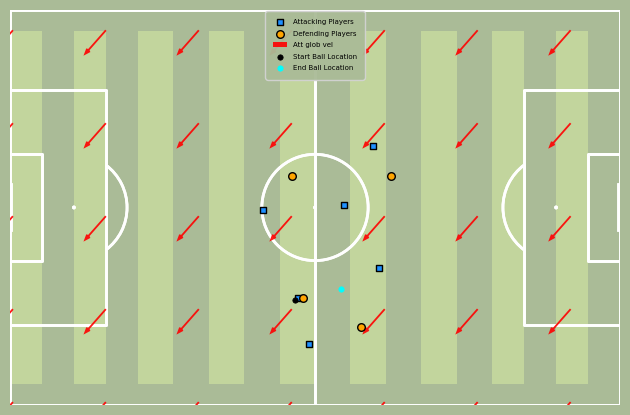

In [5]:



# 1) Just the ball velocity field:
fig, ax, q = viz.plot_velocity_quiver(def_vx, def_vy, color="black", step=16)

# 2) Full state + attacking glob velocity:
fig, ax, q = viz.plot_velocity_on_state(
    in_possession=in_pos,
    out_possession=out_pos,
    vx_map=att_vx,
    vy_map=att_vy,
    quiver_kwargs={"color": "red", "step": 16, "alpha": 0.9, "label": "Att glob vel"},
)
dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y ==1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="cyan", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)



## Random Velo Sample

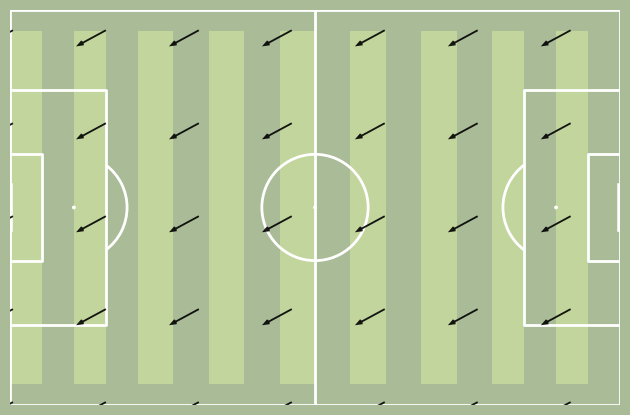

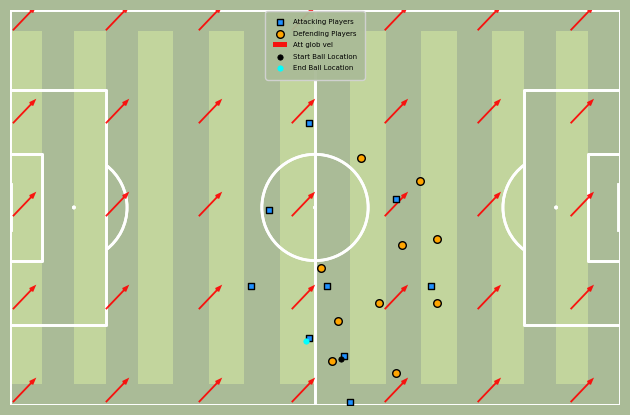

In [13]:
EXAMPLE_IDX = np.random.randint(0,20000)

X, dst_xy, y = get_example(feats, targs, EXAMPLE_IDX)


viz = SoccerVisualizer()

ball_dist = X[DIST]
in_pos = X[POS]          # (105, 68) one-hot
out_pos = X[DEF]
ball_vx = X[BVX]
ball_vy = X[BVY]
att_vx = X[AVX]
att_vy = X[AVY]
def_vx = X[DVX]
def_vy = X[DVY]


# 1) Just the ball velocity field:
fig, ax, q = viz.plot_velocity_quiver(def_vx, def_vy, color="black", step=16)

# 2) Full state + attacking glob velocity:
fig, ax, q = viz.plot_velocity_on_state(
    in_possession=in_pos,
    out_possession=out_pos,
    vx_map=att_vx,
    vy_map=att_vy,
    quiver_kwargs={"color": "red", "step": 16, "alpha": 0.9, "label": "Att glob vel"},
)
dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y ==1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="cyan", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)



In [14]:
print(EXAMPLE_IDX) #7607,14520 is buggy


19482
